In [24]:
import pandas as pd
import sys
sys.path.append("..")
import helper
import re
import html
import matplotlib.pyplot as plt
from tqdm import tqdm
import swifter

c:\Users\tungq\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_csv('../data/comments.csv')
df.head()

,emotion,video_id,author,comment
0,vui vẻ,_pMLRYGx9Is,@ottux2707,Ai đó rì viu DHHP cho em vớiii
1,vui vẻ,_pMLRYGx9Is,@minhchau3090,Tính cả mình thì khóa mình có 5 người trong Bộ...
2,vui vẻ,_pMLRYGx9Is,@yennhile8168,Ê em là 2k8 lo xa đag tìm trường đhoc:)) e xem...
3,vui vẻ,_pMLRYGx9Is,@tuantruong2080,anh làm p2 cho 2k7 đc ko
4,vui vẻ,_pMLRYGx9Is,@johnnyphim5572,FTU giỏi lắm đó


In [12]:
def clean_comment(text: str):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)  # Decode HTML entities
    text = re.sub(r"<.*?>", "", text)  # Xoá HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Xoá URL
    text = re.sub(r"@\w+", "", text)  # Xoá @user
    text = re.sub(r"[^\w\sàáảãạâấầẩẫậăắằẳẵặèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđA-Z]", " ", text, flags=re.UNICODE)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()


def filter_comments(df: pd.DataFrame, min_length: int = 5) -> pd.DataFrame:
    """
    Filter out comments that are not bring any value
    """
    df = df[df["clean_comment"].str.len() > min_length]
    df = df.dropna(subset=["clean_comment"])
    df = df[df["clean_comment"].str.strip() != ""]
    return df

In [26]:
def apply_misspelling(df: pd.DataFrame, misspelling_dict: dict = None) -> pd.DataFrame:
    """
    Apply misspelling to the comments
    """
    if misspelling_dict is None:
        misspelling_dict = get_misspelling()
    df["misspelling"] = df["clean_comment"].progress_apply(lambda x: fix_misspelling(x, misspelling_dict))
    print(f"Changed {len(df[df['misspelling'] != df['clean_comment']])} comments")
    return df

def fix_misspelling(text: str, misspelling_dict: dict) -> str:
    """
    Fix misspelling in the comments
    """
    if not isinstance(text, str):
        return ""
    for wrong, right in misspelling_dict.items():
        text = re.sub(r"\b" + re.escape(wrong) + r"\b", right, text)
    return text

def get_misspelling(file: str = "../dictionary/misspell_dataset.csv") -> dict:
    dict_pd = pd.read_csv(file)
    dict_pd = dict_pd.dropna()
    # Turn the dataframe into a dictionary of wrong and right
    dict_pd = dict_pd[["wrong", "right"]].drop_duplicates()
    # Strips leading and trailing whitespace from the "wrong" and "right" columns
    dict_pd["wrong"] = dict_pd["wrong"].str.strip()
    dict_pd["right"] = dict_pd["right"].str.strip()
    dict_pd = dict_pd.dropna()
    dict_pd = dict_pd[dict_pd["wrong"].str.strip() != ""]
    dict_pd = dict_pd[dict_pd["right"].str.strip() != ""]
    return dict_pd.set_index("wrong")["right"].to_dict()

get_misspelling()


{'chính sác': 'chính xác',
 'dân biểu liêng bang': 'dân biểu liên bang',
 'chiên sư ukraine': 'chiến sự ukraine',
 'vui vẽ': 'vui vẻ',
 'xô xác': 'xô xát',
 'cái tật sạo không bỏ': 'cái tật xạo không bỏ',
 'đầu ốc con người': 'đầu óc con người',
 'bà nầy': 'bà này',
 'chen nhau đặc vé': 'chen nhau đặt vé',
 'nguễn': 'nguyễn',
 'hà lội': 'hà nội',
 'cái ông lầy nàm thơ': 'cái ông này làm thơ',
 'dẫn nước và ruộng': 'dẫn nước vào ruộng',
 'sài lu không ăn thua gì': 'xài lu không ăn thua gì',
 'ní nuận': 'lý luận',
 'đại biểu cuốc hội': 'đại biểu quốc hội',
 "tât' cả mọi ngơi": 'tất cả mọi nơi',
 'thuối nát': 'thối nát',
 'bộ trưỡng': 'bộ trưởng',
 'ai triệu trách nhiệm': 'ai chịu trách nhiệm',
 'anh lả ai': 'anh là ai',
 'đóng phinh': 'đóng phim',
 'vuọt ngục': 'vượt ngục',
 'comment sàm': 'comment xàm',
 'người hiểu xẽ nhìn ra': 'người hiểu sẽ nhìn ra',
 'sai ghon': 'sài gòn',
 'chưởi': 'chửi',
 'giọng miền nâm': 'giọng miền nam',
 'hây hơn': 'hay hơn',
 'chần kảm': 'trầm cảm

In [27]:
# Main
tqdm.pandas()
bef_length = len(df)
df["clean_comment"] = df["comment"].apply(clean_comment)
df = filter_comments(df)
# Check misspelling
df = apply_misspelling(df)
# Change column name
df["clean_comment"] = df["misspelling"]
df = df.drop(columns=["misspelling"])
aft_length = len(df)
print(f"Removed {bef_length - aft_length} comments")
df = df.reset_index(drop=True)
df = df.drop(columns=["comment"])
df = df.rename(columns={"clean_comment": "comment"})
df.to_csv("./data/clean_comments.csv", index=False)

  3%|▎         | 188/5413 [01:10<32:43,  2.66it/s]


KeyboardInterrupt: 

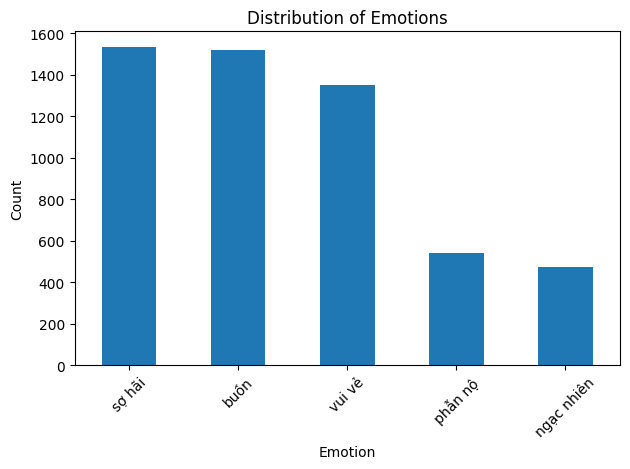

In [ ]:
# Plot distribution by emotion
def plot_distribution(df: pd.DataFrame):
    df["emotion"].value_counts().plot(kind="bar")
    plt.title("Distribution of Emotions")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("./data/emotion_distribution.png")
    plt.show()

plot_distribution(df)